In [1]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd

In [2]:
train_path = 'processedData/train'
test_path = 'processedData/test'
valid_path = 'processedData/val'

In [3]:
image_shape = (305,430,3)
N_CLASSES = 4
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_dataset = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_dataset = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 699 images belonging to 2 classes.
Found 99 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


['cancerous', 'non-cancerous']


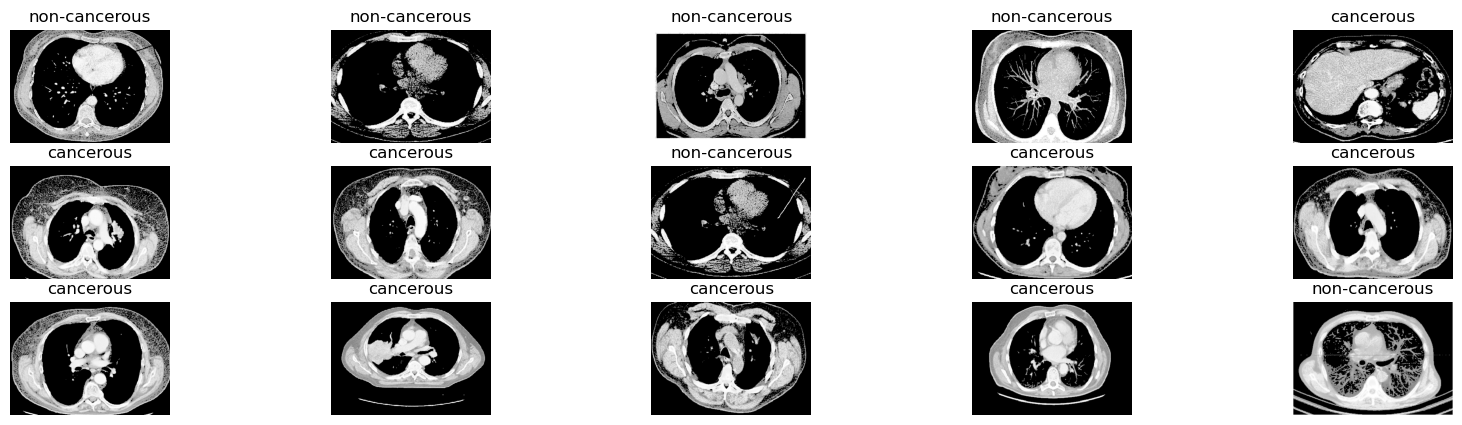

In [4]:
class_names=list(test_dataset.class_indices.keys())
print(class_names)

fig = plt.figure(figsize=(20,5))

image_batch,label_batch = test_dataset[1]
for i in range(15):
    ax = fig.add_subplot(3,5,i+1,xticks = [], yticks = [])
    ax.imshow(image_batch[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label_batch[i])])

In [6]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),  
      tf.keras.metrics.AUC(name='AUC')
]


In [7]:
CNN = tf.keras.Sequential()
CNN.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN.add(tf.keras.layers.Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Flatten())
CNN.add(tf.keras.layers.Dense(units=64, activation='relu'))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

CNN.summary()

CNN.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 36)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [8]:
""""checkpointer = ModelCheckpoint('CNN.h5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001, decay=1e-5)"""


lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('CNN.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

CNN_history = CNN.fit(train_dataset,validation_data=valid_dataset, epochs = 5,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/Relu' defined at (most recent call last):
    File "C:\Users\mayur\anaconda3.0\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\mayur\anaconda3.0\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\mayur\anaconda3.0\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\mayur\anaconda3.0\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\mayur\anaconda3.0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\mayur\AppData\Local\Temp\ipykernel_24264\3235488873.py", line 12, in <module>
      CNN_history = CNN.fit(train_dataset,validation_data=valid_dataset, epochs = 5,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\activations.py", line 321, in relu
      return backend.relu(
    File "C:\Users\mayur\anaconda3.0\lib\site-packages\keras\src\backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'sequential/dense/Relu'
Matrix size-incompatible: In[0]: [32,235008], In[1]: [86528,64]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_train_function_2276]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
result = first_model.evaluate(test_generator)

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

In [ ]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers not trainable
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

In [ ]:
densenet_model = Sequential()
densenet_model.add(dense_model)
densenet_model.add(Flatten())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(N_CLASSES, activation='softmax'))
densenet_model.summary()

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
densenet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

checkpointer = ModelCheckpoint(filepath='./chestmodel-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_dense = densenet_model.fit(train_generator,
                                steps_per_epoch = 20,
                                epochs = 80,
                                verbose = 1,
                                validation_data = valid_generator,
                                callbacks = [checkpointer, early_stopping])

In [ ]:
plt.plot(history_dense.history['acc'], label = 'train',)
plt.plot(history_dense.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:

dns_result = densenet_model.evaluate(test_generator)

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32')
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32')
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32')
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

In [ ]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers not trainable
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

In [ ]:
resnet_model = Sequential()
resnet_model.add(res_model)
resnet_model.add(Dropout(0.4))
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(N_CLASSES, activation='softmax'))
resnet_model.summary()

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
resnet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='./finalmodel-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

In [ ]:
history_res = resnet_model.fit(train_generator,
                            steps_per_epoch = 20,
                            epochs = 120,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
result = resnet_model.evaluate(test_generator)

In [ ]:
from keras.models import load_model
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img
model = load_model('/content/drive/MyDrive/ml-projects/lung-cancer-detection/trainedmodel_version3.hdf5')

In [ ]:
paths = ["/content/drive/MyDrive/Data/test/adenocarcinoma", "/content/drive/MyDrive/Data/test/large.cell.carcinoma", "/content/drive/MyDrive/Data/test/normal", "/content/drive/MyDrive/Data/test/squamous.cell.carcinoma"]
results = {"adeno":{0:0, 1:0, 2:0, 3:0},
            "large":{0:0, 1:0, 2:0, 3:0},
            "normal":{0:0, 1:0, 2:0, 3:0},
            "squamous":{0:0, 1:0, 2:0, 3:0}}

for path, key in zip(paths, results.keys()):
    
    for file in os.listdir(path):
        img = load_img(
            (path +"/"+ file), target_size=(460, 460)
        )
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, 0)
        prediction = model.predict(img_array, verbose=0)
        results[key][np.argmax(prediction)] = results.get(key).get(np.argmax(prediction),0) + 1

results

In [ ]:
df = pd.DataFrame(results)

print("Overall accuracy is : {:.2f}%\n".format((df["adeno"][0] + df["large"][1] + df["normal"][2] + df["squamous"][3]) / 315 * 100))

print("Adeno cancer detection accuracy is : {:.2f}%".format(df["adeno"][0] / df["adeno"].sum() * 100))
print("Large cell cancer detection accuracy is : {:.2f}%".format(df["large"][1] / df["large"].sum() * 100))
print("Normal chest detection accuracy is : {:.2f}%".format(df["normal"][2] / df["normal"].sum() * 100))
print("Squamous cell cancer detection accuracy is : {:.2f}%".format(df["squamous"][3] / df["squamous"].sum() * 100))

print("\nConfusion Matrix :")
df.transpose()

In [ ]:
img_path = "/content/drive/MyDrive/Data/test/large.cell.carcinoma/000108.png"

class_names=list(test_generator.class_indices.keys())

img = tf.keras.utils.load_img(img_path, target_size=(460, 460))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = model.predict(img_array)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
)